2. Data Preprocessing & Feature Engineering
Project: CryptoGigel

Objective: Raw prices (Open, Close) are rarely enough for a good prediction model. In this notebook, we transform raw data into a "Feature-Rich" dataset.

Key Steps:

Robust Loading: Re-load and clean data (ensuring reproducibility).

Feature Engineering: Calculate Technical Indicators (SMA, RSI, Volatility).

Target Creation: Define what we want to predict (Next Day Price & Direction).

Export: Save the processed dataset for the Model Training stage.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Data (Robust Method)
# We re-implement the cleaning logic here to make this notebook self-contained.
file_path = '../data/raw/bitcoin_raw.csv'

# Load CSV
df = pd.read_csv(file_path)

# Fix Multi-Index Header (if present)
if "Ticker" in df.iloc[0].values or "BTC-USD" in df.iloc[0].values:
    df = pd.read_csv(file_path, header=[0, 1])
    df.columns = df.columns.droplevel(1)

# Fix Date Index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Force Numeric Types
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove any initial garbage rows
df.dropna(inplace=True)

print("Data loaded for preprocessing.")
display(df.tail())

Data loaded for preprocessing.


,Close,High,Low,Open,Volume
Date,,,,,
2024-11-26,91985.320312,94991.750000,90770.812500,93087.281250,91656519855
2024-11-27,95962.531250,97361.179688,91778.664062,91978.140625,71133452438
2024-11-28,95652.468750,96650.203125,94677.351562,95954.945312,52260008261
2024-11-29,97461.523438,98693.171875,95407.882812,95653.953125,54968682476
2024-11-30,96449.054688,97499.343750,96144.218750,97468.812500,31634227866


2. Feature Engineering (Technical Indicators)
We are adding "intelligence" to the dataset.

SMA (Simple Moving Average): Helps the model see the trend by smoothing out noise. SMA_7 is short-term, SMA_30 is medium-term.

Volatility: Measures risk/fear in the market.

RSI (Relative Strength Index): A momentum indicator.

RSI > 70: Market is Overbought (Price might drop).

RSI < 30: Market is Oversold (Price might rise).

In [13]:
# 1. Trend Indicators: SMA
# SMA_7: Fast trend (reacts quickly to price changes)
df['SMA_7'] = df['Close'].rolling(window=7).mean()

# SMA_30: Slow trend (shows the general direction)
df['SMA_30'] = df['Close'].rolling(window=30).mean()

# 2. Momentum Indicator: Daily Returns
# ML models often prefer % change over raw dollar values
df['Pct_Change'] = df['Close'].pct_change()

# 3. Risk Indicator: Volatility
# Rolling Standard Deviation over 7 days
df['Volatility'] = df['Close'].rolling(window=7).std()

# 4. Momentum Indicator: RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    """Calculates the Relative Strength Index (RSI) for a given window."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

print("Feature Engineering Complete: Added SMA, Volatility, and RSI.")

Feature Engineering Complete: Added SMA, Volatility, and RSI.


3. Handling NaN Values
Calculating moving averages creates empty spaces (NaN) at the beginning of the dataset.

Example: You can't calculate a 30-day average for the 1st day of data.

Action: We drop these initial rows. It's a small loss of data for a cleaner dataset.

In [14]:
# Check how many NaNs were generated by rolling windows
print("NaN values before cleaning:")
print(df.isna().sum())

# Drop the initial rows that lack sufficient history for SMA_30
df.dropna(inplace=True)

print(f"\nCleaned Data Shape: {df.shape}")

NaN values before cleaning:
Close          0
High           0
Low            0
Open           0
Volume         0
SMA_7          6
SMA_30        29
Pct_Change     1
Volatility     6
RSI           13
dtype: int64

Cleaned Data Shape: (1767, 10)


4. Creating Targets (The "Y" Variable)
This is the most critical step. We need to define what the model learns. We use .shift(-1) to bring tomorrow's value onto today's row.

Regression Target (Target_Next_Close): The exact price of tomorrow.

Classification Target (Target_Direction):

1: Price goes UP tomorrow.

0: Price goes DOWN (or stays same) tomorrow.

In [15]:
# --- 1. REGRESSION TARGET ---
# We want to predict the 'Close' price of the NEXT DAY.
# We look into the future by shifting the column UP by 1 position.
df['Target_Next_Close'] = df['Close'].shift(-1)

# --- 2. CLASSIFICATION TARGET ---
# Logic: If Next_Close > Current_Close -> 1 (UP), else 0 (DOWN)
df['Target_Direction'] = (df['Target_Next_Close'] > df['Close']).astype(int)

# The shift operation creates one last NaN row at the very end (tomorrow doesn't exist yet)
# We must remove it, or the model will crash.
df.dropna(inplace=True)

print("Targets created successfully.")
display(df[['Close', 'Target_Next_Close', 'Target_Direction']].tail())

Targets created successfully.


,Close,Target_Next_Close,Target_Direction
Date,,,
2024-11-25,93102.296875,91985.320312,0
2024-11-26,91985.320312,95962.531250,1
2024-11-27,95962.531250,95652.468750,0
2024-11-28,95652.468750,97461.523438,1
2024-11-29,97461.523438,96449.054688,0


5. Visualizing Features
A quick visual check to ensure our indicators look correct.

Top Plot: Price vs SMAs. When the Orange line (SMA 7) crosses above the Green line (SMA 30), it's often a "Buy Signal" (Golden Cross).

Bottom Plot: RSI. We add red/green lines to mark Overbought/Oversold zones.

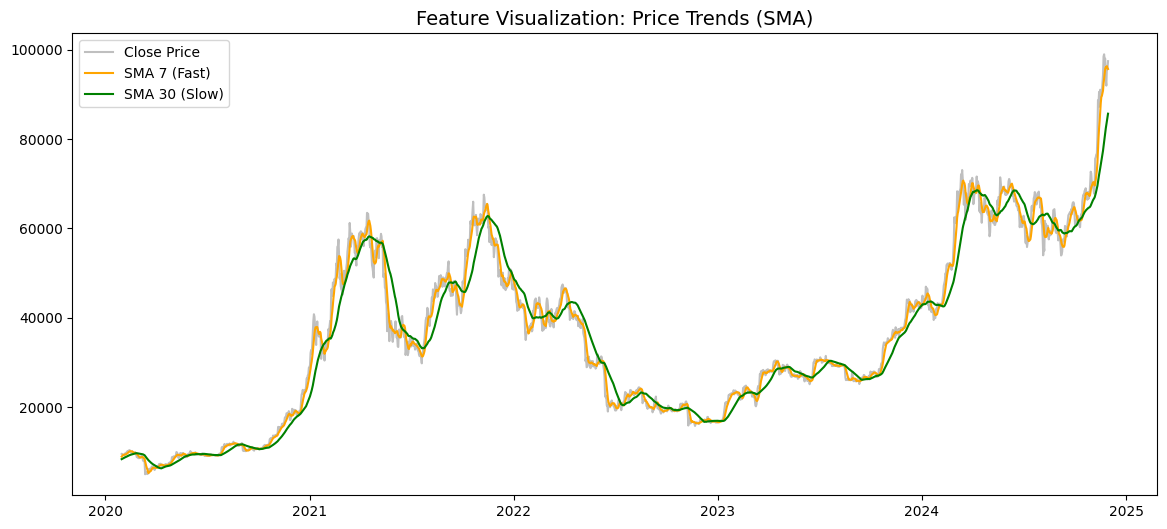

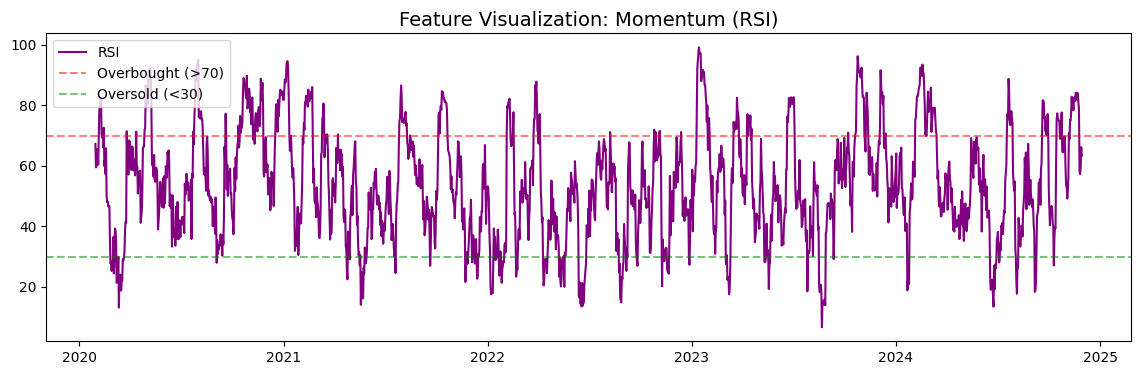

In [16]:
# Plotting Price with Moving Averages

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5, color='gray')
plt.plot(df.index, df['SMA_7'], label='SMA 7 (Fast)', color='orange', linewidth=1.5)
plt.plot(df.index, df['SMA_30'], label='SMA 30 (Slow)', color='green', linewidth=1.5)
plt.title('Feature Visualization: Price Trends (SMA)', fontsize=14)
plt.legend()
plt.show()

# Plotting RSI

plt.figure(figsize=(14, 4))
plt.plot(df.index, df['RSI'], color='purple', label='RSI')

# Add reference lines for Overbought/Oversold
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (>70)') 
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label='Oversold (<30)') 

plt.title('Feature Visualization: Momentum (RSI)', fontsize=14)
plt.legend(loc='upper left')
plt.show()

6. Export Processed Data
Finally, we save this "ML-Ready" dataset. The next notebooks (Model Training) will load this file directly.

In [17]:
import os

# Create directory if it doesn't exist
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')

# Save to CSV
output_path = '../data/processed/bitcoin_processed.csv'
df.to_csv(output_path)

print(f"Success! Processed dataset saved to: {output_path}")

Success! Processed dataset saved to: ../data/processed/bitcoin_processed.csv
